# 14-6. 프로젝트: 한국어 QA 모델 만들기

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
from ckonlpy.tag import Twitter
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

## Step 1. 데이터 셋 준비

In [2]:
# 환경에 맞게 경로 적절히 수정
DATA_DIR = os.getenv('HOME')+'/aiffel/memory_network'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [3]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [4]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [5]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [6]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [7]:
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

10000
10000
10000
1000
1000
1000


In [8]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [9]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [10]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

## Step 2. tokenizer

In [11]:
names = []

for i in range(10000):
    sen_list = train_stories[i]
    for j in range(0, len(sen_list)):
        sen = sen_list[j].split(' ')
        name = sen[0][:-1]
        if name not in names:
            names.append(name)

In [12]:
names

['필웅이', '은경이', '수종이', '경임이']

In [13]:
twitter = Twitter()

for name in names:
    twitter.add_dictionary(name, 'Noun')
    print(name)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


필웅이
은경이
수종이
경임이


## Step 3. 형태소 분석 후 불용어 처리하기

In [14]:
stopwords = ['는', '로', '으로']

In [15]:
# def preprocess_data(train_data, test_data):
#     counter = FreqDist()
    
#     # 두 문장의 story를 하나의 문장으로 통합하는 함수
#     flatten = lambda data: reduce(lambda x, y: x + y, data)

#     # 각 샘플의 길이를 저장하는 리스트
#     story_len = []
#     question_len = []
    
#     for stories, questions, answers in [train_data, test_data]:
#         for story in stories:
#             stories = twitter.morphs(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
#             story_len.append(len(stories)) # 각 story의 길이 저장
#             for word in stories: # 단어 집합에 단어 추가
#                 counter[word] += 1
#         for question in questions:
#             question = twitter.morphs(question)
#             question_len.append(len(question))
#             for word in question:
#                 counter[word] += 1
#         for answer in answers:
#             answer = twitter.morphs(answer)
#             for word in answer:
#                 counter[word] += 1

#     # 단어장 생성
#     word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
#     idx2word = {idx : word for word, idx in word2idx.items()}

#     # 가장 긴 샘플의 길이
#     story_max_len = np.max(story_len)
#     question_max_len = np.max(question_len)

#     return word2idx, idx2word, story_max_len, question_max_len

In [16]:
def preprocess_data(train_data, test_data): #불용어 사용
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = twitter.morphs(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                if word not in stopwords:
                    counter[word] += 1
        for question in questions:
            question = twitter.morphs(question)
            question_len.append(len(question))
            for word in question:
                if word not in stopwords:
                    counter[word] += 1
        for answer in answers:
            answer = twitter.morphs(answer)
            for word in answer:
                if word not in stopwords:
                    counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [17]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [18]:
print(word2idx)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '야': 19, '?': 20}


In [40]:
print(idx2word)

{1: '.', 2: '했습니다', 3: '경임이', 4: '은경이', 5: '수종이', 6: '필웅이', 7: '이동', 8: '가버렸습니다', 9: '뛰어갔습니다', 10: '복귀', 11: '화장실', 12: '정원', 13: '복도', 14: '갔습니다', 15: '사무실', 16: '부엌', 17: '침실', 18: '어디', 19: '야', 20: '?'}


In [19]:
vocab_size = len(word2idx) + 1

In [41]:
#vocab에 pad 추가

word2idx['<pad>'] = 0
idx2word[0] = '<pad>'

In [42]:
print(word2idx)
print(idx2word)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '야': 19, '?': 20, '<pad>': 0}
{1: '.', 2: '했습니다', 3: '경임이', 4: '은경이', 5: '수종이', 6: '필웅이', 7: '이동', 8: '가버렸습니다', 9: '뛰어갔습니다', 10: '복귀', 11: '화장실', 12: '정원', 13: '복도', 14: '갔습니다', 15: '사무실', 16: '부엌', 17: '침실', 18: '어디', 19: '야', 20: '?', 0: '<pad>'}


In [20]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


## Step 4. vectorize

In [21]:
# def vectorize(data, word2idx, story_maxlen, question_maxlen):
#     Xs, Xq, Y = [], [], []
#     flatten = lambda data: reduce(lambda x, y: x + y, data)

#     stories, questions, answers = data
#     for story, question, answer in zip(stories, questions, answers):
#         xs = [word2idx[w] for w in twitter.morphs(flatten(story))]
#         xq = [word2idx[w] for w in twitter.morphs(question)]
#         Xs.append(xs)
#         Xq.append(xq)
#         Y.append(word2idx[answer])

#     # 스토리와 질문은 각각의 최대 길이로 패딩
#     # 정답은 원-핫 인코딩
#     return pad_sequences(Xs, maxlen=story_maxlen),\
#            pad_sequences(Xq, maxlen=question_maxlen),\
#            to_categorical(Y, num_classes=len(word2idx) + 1)

In [22]:
def vectorize(data, word2idx, story_maxlen, question_maxlen): #불용어 사용
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = []
        for w in twitter.morphs(flatten(story)):
            if w not in stopwords:
                xs.append(word2idx[w])
        
        xq = []
        for w in twitter.morphs(flatten(question)):
            if w not in stopwords:
                xq.append(word2idx[w])

        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [23]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [24]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 21) (1000, 70) (1000, 5) (1000, 21)


## Step 5. momory network

In [25]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [26]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [27]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [28]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [29]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32)
Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32)
Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32)


In [30]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)


In [31]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)


In [32]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


## Step 6. training

In [33]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/memory_network/model_with_stopwords.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8940 - acc: 0.1654 - val_loss: 1.7976 - val_acc: 0.1960
Epoch 2/120
313/313 [==============================] - 1s 2ms/step - loss: 1.7452 - acc: 0.2268 - val_loss: 1.6397 - val_acc: 0.2890
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6316 - acc: 0.3132 - val_loss: 1.5417 - val_acc: 0.3730
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5318 - acc: 0.3853 - val_loss: 1.5003 - val_acc: 0.4170
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4874 - acc: 0.4194 - val_loss: 1.4567 - val_acc: 0.4480
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4309 - acc: 0.4569 - val_loss: 1.4098 - val_acc: 0.4390
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3801 - acc: 0.4759 - val_loss: 1.3781 - val_acc: 0.4780
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.3735 - acc: 0.8653 - val_loss: 0.4518 - val_acc: 0.8360
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3606 - acc: 0.8695 - val_loss: 0.4486 - val_acc: 0.8420
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3482 - acc: 0.8717 - val_loss: 0.4132 - val_acc: 0.8550
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3308 - acc: 0.8831 - val_loss: 0.4258 - val_acc: 0.8440
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3208 - acc: 0.8839 - val_loss: 0.4237 - val_acc: 0.8450
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3113 - acc: 0.8852 - val_loss: 0.3991 - val_acc: 0.8480
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.3041 - acc: 0.8875 - val_loss: 0.4136 - val_acc: 0.8490
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [34]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.3441 - acc: 0.9070

 테스트 정확도: 0.9070


불용어 미 사용시 테스트 정확도: 0.9190

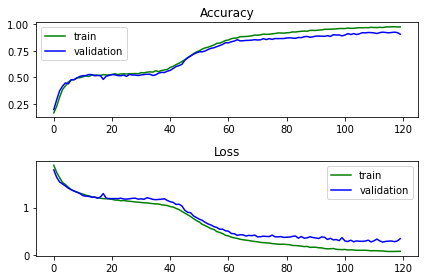

In [35]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

stopwords 사용시 학습 그래프

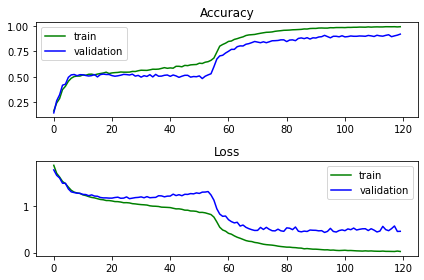

In [39]:
print(Xqtest[0])

print(idx2word)
print(word2idx)

[ 0  4 18 19 20]
{1: '.', 2: '했습니다', 3: '경임이', 4: '은경이', 5: '수종이', 6: '필웅이', 7: '이동', 8: '가버렸습니다', 9: '뛰어갔습니다', 10: '복귀', 11: '화장실', 12: '정원', 13: '복도', 14: '갔습니다', 15: '사무실', 16: '부엌', 17: '침실', 18: '어디', 19: '야', 20: '?'}
{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '야': 19, '?': 20}


In [37]:
a = Xqtest[100]

for i in a:
    if i != 0:
        print(idx2word[i])

필웅이
어디
야
?


In [43]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
<pad> 은경이 어디 야 ?    : 복도      복도
<pad> 필웅이 어디 야 ?    : 화장실     화장실
<pad> 경임이 어디 야 ?    : 부엌      부엌
<pad> 경임이 어디 야 ?    : 복도      복도
<pad> 경임이 어디 야 ?    : 부엌      부엌
<pad> 경임이 어디 야 ?    : 복도      복도
<pad> 경임이 어디 야 ?    : 정원      정원
<pad> 수종이 어디 야 ?    : 복도      복도
<pad> 경임이 어디 야 ?    : 사무실     사무실
<pad> 수종이 어디 야 ?    : 사무실     정원
<pad> 필웅이 어디 야 ?    : 부엌      부엌
<pad> 필웅이 어디 야 ?    : 정원      정원
<pad> 수종이 어디 야 ?    : 사무실     사무실
<pad> 필웅이 어디 야 ?    : 침실      침실
<pad> 필웅이 어디 야 ?    : 침실      침실
<pad> 은경이 어디 야 ?    : 부엌      부엌
<pad> 은경이 어디 야 ?    : 정원      정원
<pad> 은경이 어디 야 ?    : 부엌      부엌
<pad> 수종이 어디 야 ?    : 사무실     사무실
<pad> 은경이 어디 야 ?    : 부엌      화장실
<pad> 필웅이 어디 야 ?    : 복도      복도
<pad> 은경이 어디 야 ?    : 사무실     사무실
<pad> 은경이 어디 야 ?    : 사무실     사무실
<pad> 경임이 어디 야 ?    : 복도      복도
<pad> 수종이 어디 야 ?    : 침실      침실
<pad> 경임이 어디 야 ?    : 침실      침실
<pad> 필웅이 어디 야 ?    : 침실      침실
<pad> 수종이 어디 야 ?    : 부엌      부엌


## Step 7. 총평

불용어, 는, 로, 으로 등을 제거하자 학습 속도 자체는 상당히 빨라졌다. 다만 정확도는 소폭 감소하였다.